# Imports:

In [1]:
# Makes sure to reload modules when they change
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from src.ensemble import multitask_loss
from torch.amp import GradScaler, autocast
import joblib
from tqdm import tqdm
from PIL import Image, ImageOps
from src.ensemble import create_region_labels

# --- CUSTOM IMPORTS ---
from src.utils import extractCoordinates, aspect_crop, haversine_distance, plot_images_from_dataloader, setup_TensorBoard_writers, log_error_map
from src.dataset import GeolocalizationDataset
from src.models import ConvNet, ConvNet2, ConvNet3, PretrainedResNet, GeoCLIP, GeoDINO
from src.ensemble import *

torch.backends.cudnn.benchmark = True

d:\programming_projects\university\geolocalization-ai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image preprocessing:

In [2]:
# Setup paths
RAW_IMAGE_FOLDER = r"data_manual_gps_united"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed_CLIP" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 1475:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((224, 224), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Pre-processed images already exist. Skipping preprocessing step.


# Data loading:

In [3]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # --- 3. SCALING PHASE ---
    # must fit on training data *only*
    scaler = MinMaxScaler()
    train_df[['lat', 'lon']] = scaler.fit_transform(train_df[['lat', 'lon']])
    val_df[['lat', 'lon']] = scaler.transform(val_df[['lat', 'lon']])

    joblib.dump(scaler, SCALER_SAVE_PATH)

Initializing train dataset...
Caching 1180 images in RAM...


100%|██████████| 1180/1180 [00:18<00:00, 65.42it/s]


Initializing validation dataset...
Caching 295 images in RAM...


100%|██████████| 295/295 [00:03<00:00, 84.72it/s]


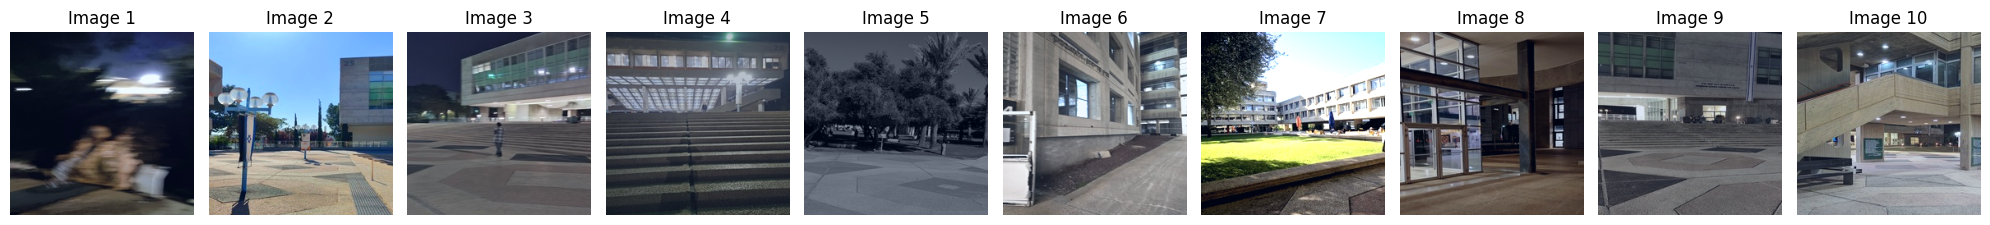

In [4]:
if __name__ == "__main__":

    # --- 4. DATASET INITIALIZATION ---
    print("Initializing train dataset...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        is_train=True
    )
    print("Initializing validation dataset...")
    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        is_train=False
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0, 
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0, 
        pin_memory=False)
    
    plot_images_from_dataloader(train_loader)

# Model setup:

In [5]:
# --- 6. INITIALIZE MODEL ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_rtx = "RTX" in torch.cuda.get_device_name(0)
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

model = GeoCLIP(dropout_rate=0.7).to(device)

if is_rtx:
    print("RTX card detected: Enabling AMP/Channels_Last optimizations")
    model = model.to(memory_format=torch.channels_last) # Optimize for modern GPUs that prefer channels_last
else:
    print("RTX card not detected: Disabling AMP/Channels_Last optimizations")
    model = model.to(device)

# --- 7. LOSS & OPTIMIZER ---
patience_counter = 0
early_stopping_patience = 20
epochs = 60
use_TensorBoard = False 

criterion = torch.nn.HuberLoss(delta=1.0)

# OPTIMIZER - Start with only training the head
print(f"Detected Model ({type(model).__name__}): Optimizing ACTIVE parameters only.")

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4,  # Lower LR for CLIP
    weight_decay=0.01
)

# SCHEDULER
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=epochs, 
    eta_min=1e-6
)

print(f"Training on {len(train_dataset)} images...")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce GTX 1070
Loading openai/clip-vit-base-patch16...
RTX card not detected: Disabling AMP/Channels_Last optimizations
Detected Model (GeoCLIP): Optimizing ACTIVE parameters only.
Training on 1180 images...


# Model training:

In [ ]:
# ============================================================================
# 🚀 FINAL ENSEMBLE TRAINING (ViT Only - Specific Layer Indexing)
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import datetime
from torch.utils.tensorboard import SummaryWriter

# 1. STORAGE FOR PLOTTING LATER
all_histories = {} 

# 2. DEFINE THE 3 ViT MODELS
ensemble_configs = [
    # Model 1: OpenAI Base Patch32 (Fast)
    {"name": "openai/clip-vit-base-patch32",         "lr": 5e-4, "save_as": "model_patch32.pth", "run_name": "Run_Patch32"},
    
    # Model 2: OpenAI Base Patch16 (Detailed)
    {"name": "openai/clip-vit-base-patch16",         "lr": 3e-4, "save_as": "model_patch16.pth", "run_name": "Run_Patch16"},

    # Model 3: LAION Base Patch32 (Different Data, Same Architecture)
    {"name": "laion/CLIP-ViT-B-32-laion2B-s34B-b79K", "lr": 5e-4, "save_as": "model_laion32.pth", "run_name": "Run_Laion32"}
]

stored_models = []

print(f"🚀 STARTING ENSEMBLE TRAINING ({len(ensemble_configs)} Architectures)")

# --- OUTER LOOP: Iterate through architectures ---
for run_idx, config in enumerate(ensemble_configs):
    
    model_name = config['name']
    save_path = config['save_as']
    run_name = config['run_name']
    
    print(f"\n" + "="*60)
    print(f"🎬 TRAINING MODEL {run_idx+1}/{len(ensemble_configs)}: {model_name}")
    print("="*60)

    # A. Initialize Simple Model
    model = GeoCLIP(
        dropout_rate=0.5, 
        model_name=model_name
    ).to(device)
    
    if is_rtx: model = model.to(memory_format=torch.channels_last)
    
    # B. Setup Optimizer
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=config['lr'], 
        weight_decay=0.02
    )
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    gradScaler = GradScaler('cuda')
    
    # C. Reset Metrics for this run
    train_losses, val_losses, val_dist_history = [], [], []
    best_dist = float("inf")
    patience_counter = 0
    
    # D. TensorBoard
    if use_TensorBoard:
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        writer_train = SummaryWriter(log_dir=f'runs/{run_name}_{current_time}/train')
        writer_val   = SummaryWriter(log_dir=f'runs/{run_name}_{current_time}/val')

    # --- INNER LOOP: Epochs ---
    for epoch in range(epochs):
        
        # === STAGE 2: UNFREEZE LAST 2 LAYERS (Epoch 10) ===
        if epoch == 10:
            print("\n>>> UNFREEZING LAST 2 LAYERS <<<")
            model.unfreeze_last_layers(num_layers=2)
            
            # REVERTED TO SPECIFIC LAYERS (Safe for ViT models)
            optimizer = torch.optim.AdamW([
                {"params": model.backbone.vision_model.encoder.layers[-2:].parameters(), "lr": config['lr'] * 0.1},
                {"params": model.head.parameters(), "lr": config['lr']} 
            ], weight_decay=0.01)
            
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-epoch, eta_min=1e-6)
            patience_counter = 0 

        # === STAGE 3: UNFREEZE LAST 4 LAYERS (Epoch 25) ===
        if epoch == 25:
            print("\n>>> UNFREEZING LAST 4 LAYERS <<<")
            model.unfreeze_last_layers(num_layers=4)
            
            # REVERTED TO SPECIFIC LAYERS (Safe for ViT models)
            optimizer = torch.optim.AdamW([
                {"params": model.backbone.vision_model.encoder.layers[-4:].parameters(), "lr": config['lr'] * 0.05},
                {"params": model.head.parameters(), "lr": config['lr'] * 0.5}
            ], weight_decay=0.01)
            
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-epoch, eta_min=1e-7)
            patience_counter = 0

        # --- PHASE 1: TRAINING ---
        model.train()
        train_running_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, unit="batch")
        
        for images, labels, *args in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            if is_rtx: images = images.to(memory_format=torch.channels_last)

            optimizer.zero_grad(set_to_none=True)

            if is_rtx:
                with autocast('cuda', dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                gradScaler.scale(loss).backward() 
                gradScaler.step(optimizer)        
                gradScaler.update()  
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            train_running_loss += loss.item()

        # --- PHASE 2: VALIDATION ---
        model.eval()
        val_running_loss = 0.0
        raw_preds, raw_trues = [], []

        with torch.no_grad():
            for images, labels, *args in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(images) 
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                raw_preds.append(outputs.cpu().numpy())
                raw_trues.append(labels.cpu().numpy())

        # --- PHASE 3: METRICS ---
        real_preds = scaler.inverse_transform(np.vstack(raw_preds))
        real_trues = scaler.inverse_transform(np.vstack(raw_trues))
        distances = haversine_distance(real_preds, real_trues)
        avg_dist_error = np.mean(distances)
        
        avg_train_loss = train_running_loss / len(train_loader)
        avg_val_loss = val_running_loss / len(val_loader)

        if use_TensorBoard:
            writer_train.add_scalar('Total Loss', avg_train_loss, epoch)
            writer_val.add_scalar('Total Loss', avg_val_loss, epoch)
            writer_val.add_scalar('Distance Error (m)', avg_dist_error, epoch)
        else:
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            val_dist_history.append(avg_dist_error)

        print(f"Epoch {epoch+1}: Train Error {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f} | Dist Error {avg_dist_error:.1f}m")
        scheduler.step()

        # --- SAVE BEST ---
        if avg_dist_error < best_dist:
            best_dist = avg_dist_error
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"   *** NEW BEST: {best_dist:.1f}m ***")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⏹ Early stopping for {model_name}.")
                break
                
    if use_TensorBoard:
        writer_train.close()
        writer_val.close()
        
    # === HISTORY SAVING ===
    all_histories[model_name] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'dist_error': val_dist_history,
        'best_dist': best_dist
    }
    
    print(f"✅ Finished {model_name}. Best Error: {best_dist:.2f}m. Saved to {save_path}")
    stored_models.append(save_path)

print("\n🏆 ENSEMBLE TRAINING COMPLETE.")

🚀 STARTING ENSEMBLE TRAINING (2 Architectures)

🎬 TRAINING MODEL 1/2: openai/clip-vit-base-patch16
Loading openai/clip-vit-base-patch16...


Epoch 1: Train Error 0.1004 | Val Loss 0.0320 | Dist Error 80.2m
   *** NEW BEST: 80.2m ***


Epoch 2: Train Error 0.0470 | Val Loss 0.0190 | Dist Error 52.0m
   *** NEW BEST: 52.0m ***


Epoch 3: Train Error 0.0346 | Val Loss 0.0186 | Dist Error 51.1m
   *** NEW BEST: 51.1m ***


Epoch 4: Train Error 0.0297 | Val Loss 0.0176 | Dist Error 49.1m
   *** NEW BEST: 49.1m ***


Epoch 5: Train Error 0.0272 | Val Loss 0.0162 | Dist Error 46.0m
   *** NEW BEST: 46.0m ***


Epoch 6: Train Error 0.0244 | Val Loss 0.0158 | Dist Error 45.2m
   *** NEW BEST: 45.2m ***


Epoch 7: Train Error 0.0228 | Val Loss 0.0159 | Dist Error 46.2m


Epoch 8: Train Error 0.0216 | Val Loss 0.0158 | Dist Error 43.0m
   *** NEW BEST: 43.0m ***


Epoch 9: Train Error 0.0209 | Val Loss 0.0150 | Dist Error 43.2m


Epoch 10: Train Error 0.0205 | Val Loss 0.0137 | Dist Error 41.2m
   *** NEW BEST: 41.2m ***

>>> UNFREEZING LAST 2 LAYERS <<<
Unfreezing last 2 transformer layers...


Epoch 11: Train Error 0.0213 | Val Loss 0.0127 | Dist Error 38.7m
   *** NEW BEST: 38.7m ***


Epoch 12: Train Error 0.0152 | Val Loss 0.0094 | Dist Error 30.7m
   *** NEW BEST: 30.7m ***


Epoch 13: Train Error 0.0121 | Val Loss 0.0083 | Dist Error 28.3m
   *** NEW BEST: 28.3m ***


Epoch 14: Train Error 0.0104 | Val Loss 0.0086 | Dist Error 31.3m


Epoch 15: Train Error 0.0083 | Val Loss 0.0085 | Dist Error 31.3m


Epoch 16: Train Error 0.0070 | Val Loss 0.0066 | Dist Error 25.5m
   *** NEW BEST: 25.5m ***


Epoch 17: Train Error 0.0062 | Val Loss 0.0061 | Dist Error 24.6m
   *** NEW BEST: 24.6m ***


Epoch 18: Train Error 0.0062 | Val Loss 0.0068 | Dist Error 26.4m


Epoch 19: Train Error 0.0056 | Val Loss 0.0064 | Dist Error 26.3m


Epoch 20: Train Error 0.0046 | Val Loss 0.0057 | Dist Error 23.6m
   *** NEW BEST: 23.6m ***


Epoch 21: Train Error 0.0044 | Val Loss 0.0056 | Dist Error 22.6m
   *** NEW BEST: 22.6m ***


Epoch 22: Train Error 0.0038 | Val Loss 0.0056 | Dist Error 22.6m


Epoch 23: Train Error 0.0038 | Val Loss 0.0054 | Dist Error 21.8m
   *** NEW BEST: 21.8m ***


Epoch 24: Train Error 0.0034 | Val Loss 0.0050 | Dist Error 21.8m
   *** NEW BEST: 21.8m ***


Epoch 25: Train Error 0.0032 | Val Loss 0.0054 | Dist Error 22.0m

>>> UNFREEZING LAST 4 LAYERS <<<
Unfreezing last 4 transformer layers...


Epoch 26: Train Error 0.0042 | Val Loss 0.0053 | Dist Error 21.6m
   *** NEW BEST: 21.6m ***


Epoch 27: Train Error 0.0035 | Val Loss 0.0059 | Dist Error 22.4m


Epoch 28: Train Error 0.0034 | Val Loss 0.0050 | Dist Error 21.0m
   *** NEW BEST: 21.0m ***


Epoch 29: Train Error 0.0032 | Val Loss 0.0050 | Dist Error 22.4m


Epoch 30: Train Error 0.0029 | Val Loss 0.0047 | Dist Error 21.2m


Epoch 31: Train Error 0.0030 | Val Loss 0.0053 | Dist Error 20.9m
   *** NEW BEST: 20.9m ***


Epoch 32: Train Error 0.0027 | Val Loss 0.0047 | Dist Error 19.0m
   *** NEW BEST: 19.0m ***


Epoch 33: Train Error 0.0026 | Val Loss 0.0045 | Dist Error 19.1m


Epoch 34: Train Error 0.0025 | Val Loss 0.0046 | Dist Error 19.4m


Epoch 35: Train Error 0.0023 | Val Loss 0.0041 | Dist Error 19.4m


Epoch 36: Train Error 0.0022 | Val Loss 0.0043 | Dist Error 18.4m
   *** NEW BEST: 18.4m ***


Epoch 37: Train Error 0.0023 | Val Loss 0.0043 | Dist Error 18.5m


Epoch 38: Train Error 0.0021 | Val Loss 0.0043 | Dist Error 18.2m
   *** NEW BEST: 18.2m ***


Epoch 39: Train Error 0.0020 | Val Loss 0.0045 | Dist Error 18.7m


Epoch 40: Train Error 0.0021 | Val Loss 0.0042 | Dist Error 18.7m


Epoch 41: Train Error 0.0022 | Val Loss 0.0044 | Dist Error 18.7m


Epoch 42: Train Error 0.0020 | Val Loss 0.0040 | Dist Error 18.5m


Epoch 43: Train Error 0.0020 | Val Loss 0.0041 | Dist Error 18.1m
   *** NEW BEST: 18.1m ***


Epoch 44: Train Error 0.0019 | Val Loss 0.0042 | Dist Error 18.9m


Epoch 45: Train Error 0.0017 | Val Loss 0.0040 | Dist Error 18.4m


Epoch 46: Train Error 0.0017 | Val Loss 0.0040 | Dist Error 18.5m


Epoch 47: Train Error 0.0017 | Val Loss 0.0040 | Dist Error 18.4m


Epoch 48: Train Error 0.0016 | Val Loss 0.0041 | Dist Error 18.2m


Epoch 49: Train Error 0.0017 | Val Loss 0.0040 | Dist Error 18.0m
   *** NEW BEST: 18.0m ***


Epoch 50: Train Error 0.0017 | Val Loss 0.0040 | Dist Error 18.2m


Epoch 51: Train Error 0.0017 | Val Loss 0.0038 | Dist Error 17.5m
   *** NEW BEST: 17.5m ***


Epoch 52: Train Error 0.0016 | Val Loss 0.0038 | Dist Error 17.5m


Epoch 53: Train Error 0.0016 | Val Loss 0.0039 | Dist Error 17.6m


Epoch 54: Train Error 0.0016 | Val Loss 0.0038 | Dist Error 17.4m
   *** NEW BEST: 17.4m ***


Epoch 55: Train Error 0.0016 | Val Loss 0.0038 | Dist Error 17.5m


Epoch 56: Train Error 0.0016 | Val Loss 0.0038 | Dist Error 17.5m


Epoch 57: Train Error 0.0016 | Val Loss 0.0038 | Dist Error 17.6m


Epoch 58: Train Error 0.0015 | Val Loss 0.0038 | Dist Error 17.5m


Epoch 59: Train Error 0.0016 | Val Loss 0.0038 | Dist Error 17.4m
   *** NEW BEST: 17.4m ***


Epoch 60: Train Error 0.0015 | Val Loss 0.0038 | Dist Error 17.4m
✅ Finished openai/clip-vit-base-patch16. Best Error: 17.38m. Saved to model_patch16.pth

🎬 TRAINING MODEL 2/2: laion/CLIP-ViT-B-32-laion2B-s34B-b79K
Loading laion/CLIP-ViT-B-32-laion2B-s34B-b79K...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Epoch 1: Train Error 0.0883 | Val Loss 0.0250 | Dist Error 63.3m
   *** NEW BEST: 63.3m ***


Epoch 2: Train Error 0.0382 | Val Loss 0.0207 | Dist Error 54.5m
   *** NEW BEST: 54.5m ***


Epoch 3: Train Error 0.0291 | Val Loss 0.0197 | Dist Error 51.1m
   *** NEW BEST: 51.1m ***


Epoch 4: Train Error 0.0255 | Val Loss 0.0175 | Dist Error 47.7m
   *** NEW BEST: 47.7m ***


Epoch 5: Train Error 0.0235 | Val Loss 0.0170 | Dist Error 46.9m
   *** NEW BEST: 46.9m ***


Epoch 6: Train Error 0.0228 | Val Loss 0.0157 | Dist Error 43.6m
   *** NEW BEST: 43.6m ***


Epoch 7: Train Error 0.0208 | Val Loss 0.0146 | Dist Error 41.6m
   *** NEW BEST: 41.6m ***


Epoch 8: Train Error 0.0199 | Val Loss 0.0148 | Dist Error 40.8m
   *** NEW BEST: 40.8m ***


Epoch 9: Train Error 0.0192 | Val Loss 0.0141 | Dist Error 41.3m


Epoch 10: Train Error 0.0170 | Val Loss 0.0129 | Dist Error 38.3m
   *** NEW BEST: 38.3m ***

>>> UNFREEZING LAST 2 LAYERS <<<
Unfreezing last 2 transformer layers...


Epoch 11: Train Error 0.0225 | Val Loss 0.0143 | Dist Error 38.3m


Epoch 12: Train Error 0.0154 | Val Loss 0.0128 | Dist Error 32.4m
   *** NEW BEST: 32.4m ***


Epoch 13: Train Error 0.0128 | Val Loss 0.0106 | Dist Error 30.5m
   *** NEW BEST: 30.5m ***


Epoch 14: Train Error 0.0100 | Val Loss 0.0091 | Dist Error 29.3m
   *** NEW BEST: 29.3m ***


Epoch 15: Train Error 0.0088 | Val Loss 0.0105 | Dist Error 29.6m


Epoch 16: Train Error 0.0074 | Val Loss 0.0085 | Dist Error 27.2m
   *** NEW BEST: 27.2m ***


Epoch 17: Train Error 0.0057 | Val Loss 0.0080 | Dist Error 27.2m


Epoch 18: Train Error 0.0054 | Val Loss 0.0080 | Dist Error 26.2m
   *** NEW BEST: 26.2m ***


Epoch 19: Train Error 0.0047 | Val Loss 0.0075 | Dist Error 25.5m
   *** NEW BEST: 25.5m ***


Epoch 20: Train Error 0.0042 | Val Loss 0.0070 | Dist Error 25.0m
   *** NEW BEST: 25.0m ***


Epoch 21: Train Error 0.0039 | Val Loss 0.0070 | Dist Error 24.4m
   *** NEW BEST: 24.4m ***


Epoch 22: Train Error 0.0039 | Val Loss 0.0068 | Dist Error 23.8m
   *** NEW BEST: 23.8m ***


Epoch 23: Train Error 0.0034 | Val Loss 0.0066 | Dist Error 23.7m
   *** NEW BEST: 23.7m ***


Epoch 24: Train Error 0.0034 | Val Loss 0.0064 | Dist Error 22.8m
   *** NEW BEST: 22.8m ***


Epoch 25: Train Error 0.0032 | Val Loss 0.0067 | Dist Error 24.9m

>>> UNFREEZING LAST 4 LAYERS <<<
Unfreezing last 4 transformer layers...


Epoch 26: Train Error 0.0037 | Val Loss 0.0066 | Dist Error 23.3m


Epoch 27: Train Error 0.0037 | Val Loss 0.0069 | Dist Error 23.5m


Epoch 28: Train Error 0.0039 | Val Loss 0.0063 | Dist Error 22.8m
   *** NEW BEST: 22.8m ***


Epoch 29: Train Error 0.0036 | Val Loss 0.0068 | Dist Error 22.2m
   *** NEW BEST: 22.2m ***


Epoch 30: Train Error 0.0031 | Val Loss 0.0064 | Dist Error 21.4m
   *** NEW BEST: 21.4m ***


Epoch 31: Train Error 0.0028 | Val Loss 0.0058 | Dist Error 21.9m


Epoch 32: Train Error 0.0029 | Val Loss 0.0067 | Dist Error 24.5m


Epoch 33: Train Error 0.0027 | Val Loss 0.0059 | Dist Error 21.6m


Epoch 34: Train Error 0.0026 | Val Loss 0.0059 | Dist Error 21.5m


Epoch 35: Train Error 0.0026 | Val Loss 0.0056 | Dist Error 21.2m
   *** NEW BEST: 21.2m ***


Epoch 36: Train Error 0.0023 | Val Loss 0.0059 | Dist Error 22.4m


Epoch 37: Train Error 0.0023 | Val Loss 0.0054 | Dist Error 20.3m
   *** NEW BEST: 20.3m ***


Epoch 38: Train Error 0.0023 | Val Loss 0.0055 | Dist Error 20.3m
   *** NEW BEST: 20.3m ***


Epoch 39: Train Error 0.0021 | Val Loss 0.0054 | Dist Error 20.0m
   *** NEW BEST: 20.0m ***


Epoch 40: Train Error 0.0022 | Val Loss 0.0055 | Dist Error 20.5m


Epoch 41: Train Error 0.0020 | Val Loss 0.0053 | Dist Error 19.6m
   *** NEW BEST: 19.6m ***


Epoch 42: Train Error 0.0020 | Val Loss 0.0051 | Dist Error 20.2m


Epoch 43: Train Error 0.0020 | Val Loss 0.0051 | Dist Error 19.7m


Epoch 44: Train Error 0.0019 | Val Loss 0.0053 | Dist Error 20.5m


Epoch 45: Train Error 0.0018 | Val Loss 0.0052 | Dist Error 19.9m


Epoch 46: Train Error 0.0019 | Val Loss 0.0054 | Dist Error 19.8m


Epoch 47: Train Error 0.0019 | Val Loss 0.0053 | Dist Error 19.8m


Epoch 48: Train Error 0.0018 | Val Loss 0.0051 | Dist Error 19.6m
   *** NEW BEST: 19.6m ***


Epoch 49: Train Error 0.0018 | Val Loss 0.0051 | Dist Error 19.1m
   *** NEW BEST: 19.1m ***


Epoch 50: Train Error 0.0017 | Val Loss 0.0052 | Dist Error 19.3m


Epoch 51: Train Error 0.0017 | Val Loss 0.0052 | Dist Error 19.1m


Epoch 52: Train Error 0.0017 | Val Loss 0.0052 | Dist Error 19.2m


Epoch 53: Train Error 0.0016 | Val Loss 0.0052 | Dist Error 19.2m


Epoch 54: Train Error 0.0017 | Val Loss 0.0052 | Dist Error 19.1m


Epoch 55: Train Error 0.0016 | Val Loss 0.0051 | Dist Error 19.2m


Epoch 56: Train Error 0.0016 | Val Loss 0.0051 | Dist Error 19.1m


Epoch 57: Train Error 0.0016 | Val Loss 0.0051 | Dist Error 19.0m
   *** NEW BEST: 19.0m ***


Epoch 58: Train Error 0.0016 | Val Loss 0.0051 | Dist Error 19.0m
   *** NEW BEST: 19.0m ***


Epoch 59: Train Error 0.0016 | Val Loss 0.0051 | Dist Error 19.0m


Epoch 60: Train Error 0.0016 | Val Loss 0.0051 | Dist Error 19.0m
✅ Finished laion/CLIP-ViT-B-32-laion2B-s34B-b79K. Best Error: 18.98m. Saved to model_laion32.pth

🏆 ENSEMBLE TRAINING COMPLETE.


In [12]:
# ============================================================================
# RUN THE ENSEMBLE (NO TTA)
# ============================================================================
from src.ensemble import *

# 1. Define the configuration for the ensemble class
my_models = [
    # Model 1: The Fast Generalist
    {'path': 'model_patch32.pth', 'name': 'openai/clip-vit-base-patch32'},
    
    # Model 2: The Detailed Expert
    {'path': 'model_patch16.pth', 'name': 'openai/clip-vit-base-patch16'},
    
    # Model 3: The "Outsider" (LAION - Trained on 2B different images)
    {'path': 'model_laion32.pth', 'name': 'laion/CLIP-ViT-B-32-laion2B-s34B-b79K'}
]

# 2. Initialize the Ensemble
ensemble = GeoCLIPEnsemble(my_models, device=device)

# 3. Predict on Validation Set (NO TTA)
print("Running Ensemble Inference...")
val_preds = []
val_trues = []

for images, labels, *args in val_loader:  # Handle 2 or 3 items
    images = images.to(device)

    # Single forward pass (no augmentation)
    # Expected shape: (Batch, 2)
    batch_preds = ensemble.predict(images)

    val_preds.append(batch_preds.cpu().numpy())
    val_trues.append(labels.numpy())

# 4. Calculate Final Error
flat_preds = np.vstack(val_preds)
flat_trues = np.vstack(val_trues)

# Inverse Scale
real_preds = scaler.inverse_transform(flat_preds)
real_trues = scaler.inverse_transform(flat_trues)

errors = haversine_distance(real_preds, real_trues)
print(f"\nFINAL ENSEMBLE ERROR: {np.mean(errors):.2f} meters")


Initializing Ensemble with 3 models...
Loading openai/clip-vit-base-patch32...
 ✅ Loaded openai/clip-vit-base-patch32
Loading openai/clip-vit-base-patch16...
 ✅ Loaded openai/clip-vit-base-patch16
Loading laion/CLIP-ViT-B-32-laion2B-s34B-b79K...
 ✅ Loaded laion/CLIP-ViT-B-32-laion2B-s34B-b79K
Running Ensemble Inference...

FINAL ENSEMBLE ERROR: 16.89 meters


In [14]:


# Compute error statistics
mean_error = np.mean(errors)
median_error = np.median(errors)
std_error = np.std(errors)

# Print the statistics
print(f"Mean Error: {mean_error:.2f} meters")
print(f"Median Error: {median_error:.2f} meters")
print(f"Standard Deviation of Error: {std_error:.2f} meters")

Mean Error: 16.89 meters
Median Error: 13.50 meters
Standard Deviation of Error: 16.98 meters


In [8]:
# 1. Initialize the specific model architecture
loaded_model = GeoCLIP(dropout_rate=0.5, model_name="openai/clip-vit-base-patch32").to(device)

# 2. Load the trained weights
loaded_model.load_state_dict(torch.load("model_patch32.pth", weights_only=True))
loaded_model.eval()

print("Model loaded successfully. Running inference...")

# 3. Run Inference on the entire validation loader
all_preds = []
all_trues = []

with torch.no_grad():
    for images, labels, *args in tqdm(val_loader, desc="Inference"):
        images = images.to(device)
        
        # Predict
        outputs = loaded_model(images)
        
        # Store raw outputs
        all_preds.append(outputs.cpu().numpy())
        all_trues.append(labels.numpy())

# 4. Process results
flat_preds = np.vstack(all_preds)
flat_trues = np.vstack(all_trues)

# Inverse Scale to get real lat/lon
real_preds = scaler.inverse_transform(flat_preds)
real_trues = scaler.inverse_transform(flat_trues)

# 5. Visualizattion
# Plot all points (num_points=len(real_trues))


Loading openai/clip-vit-base-patch32...
Model loaded successfully. Running inference...


Inference: 100%|██████████| 10/10 [00:00<00:00, 10.11it/s]


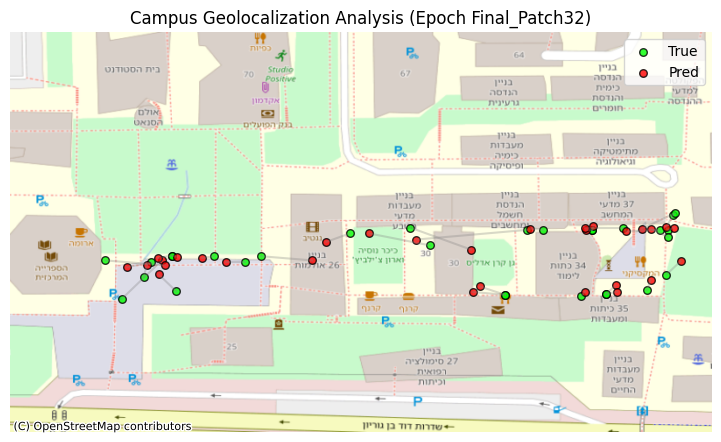

In [13]:
log_error_map(real_preds, real_trues, epoch="Final_Patch32", num_points=30)

# Plotting the results:

📈 Generating plots for 2 models...


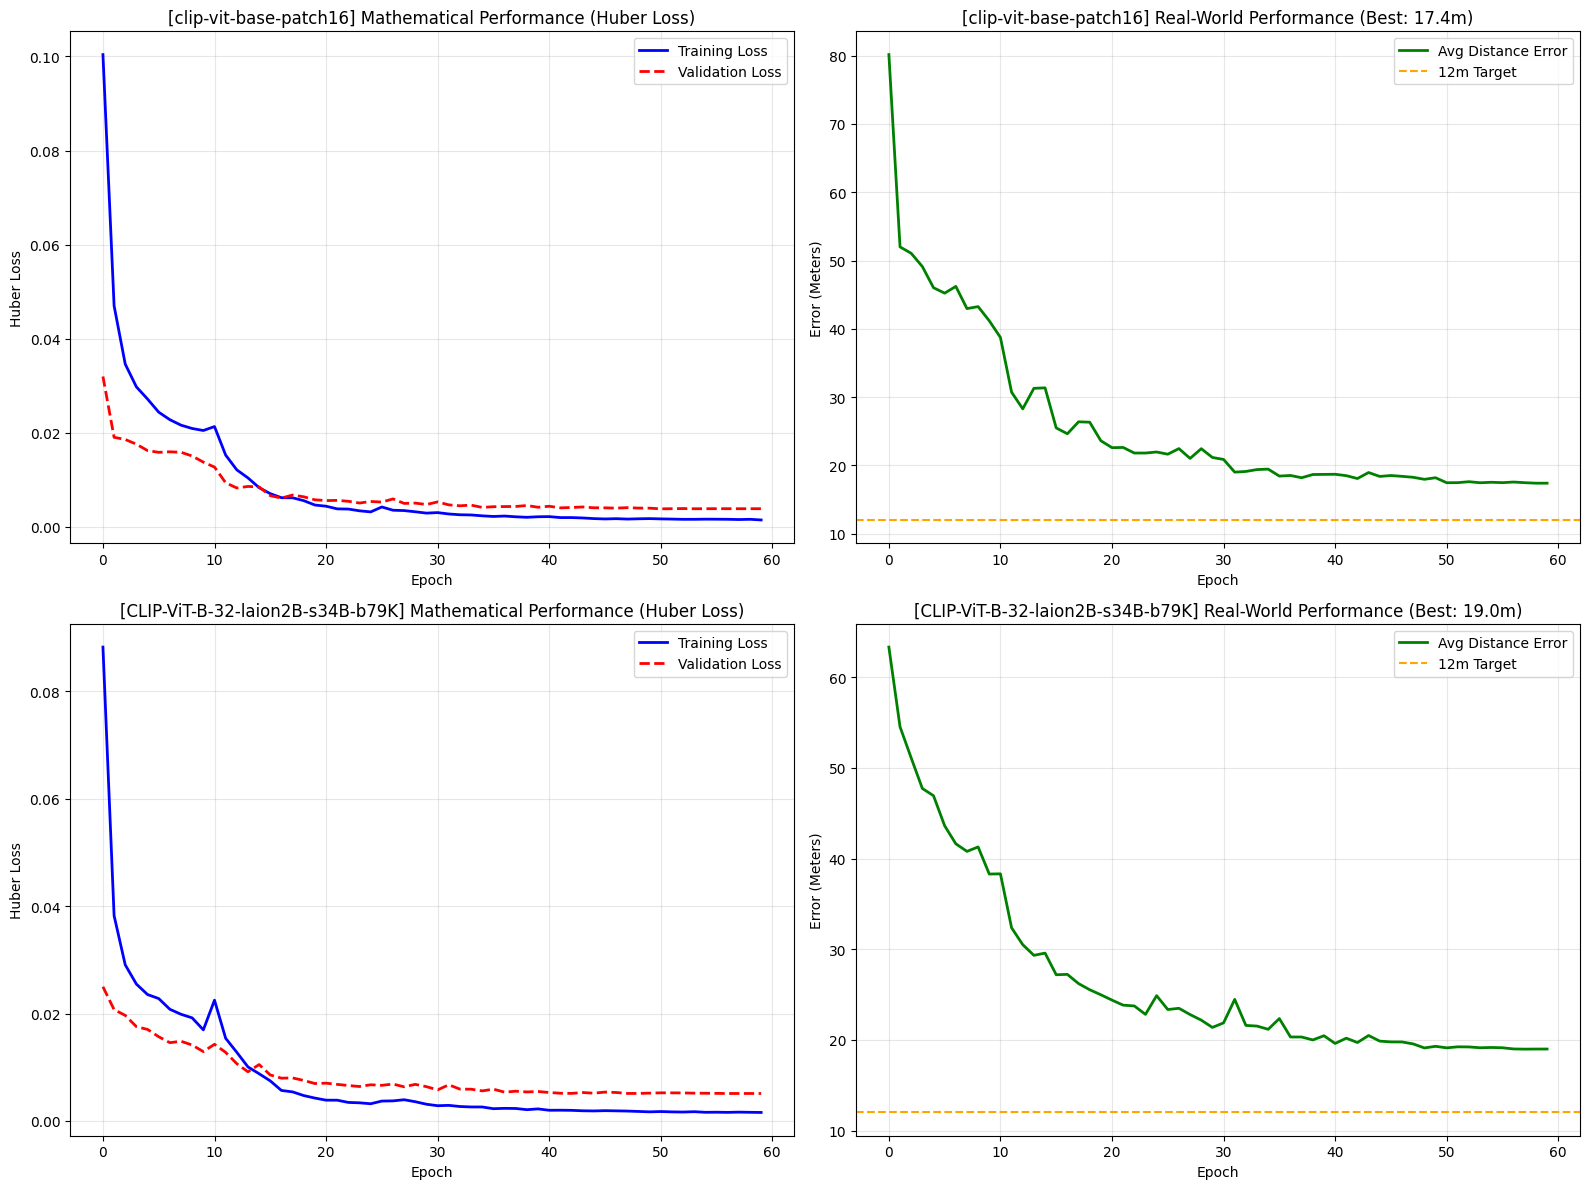

d:\programming_projects\university\geolocalization-ai\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


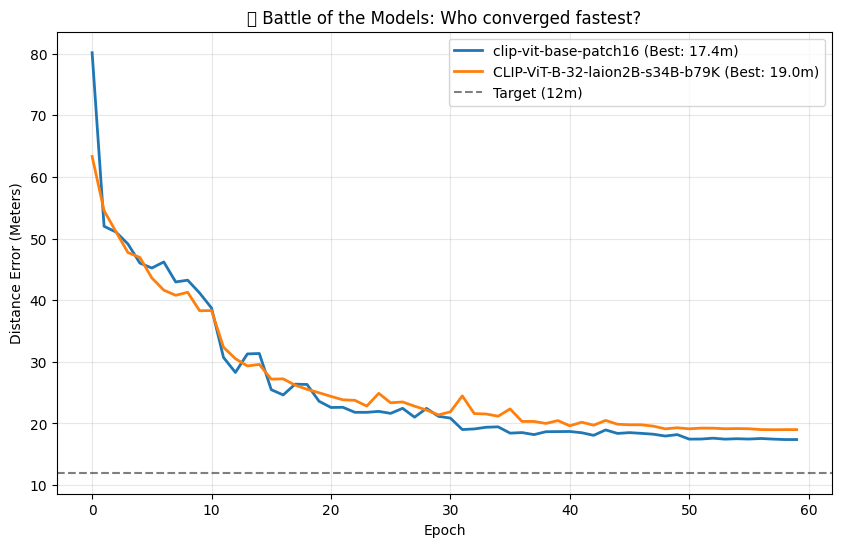

In [10]:
# ============================================================================
# 📊 ENSEMBLE TRAINING VISUALIZATION
# Run this cell after training completes.
# ============================================================================
import matplotlib.pyplot as plt

# 1. Setup the figure: One row for each model trained
n_models = len(all_histories)
fig, axes = plt.subplots(n_models, 2, figsize=(16, 6 * n_models))

# Handle the case of a single model (make axes iterable)
if n_models == 1: axes = [axes]

print(f"📈 Generating plots for {n_models} models...")

# 2. Iterate through each model's history
for idx, (model_name, history) in enumerate(all_histories.items()):
    
    # Get the specific axes for this row
    ax1 = axes[idx][0] if n_models > 1 else axes[0]
    ax2 = axes[idx][1] if n_models > 1 else axes[1]
    
    # --- PLOT 1: Huber LOSS (Left) ---
    ax1.plot(history['train_loss'], label="Training Loss", color="blue", linewidth=2)
    ax1.plot(history['val_loss'], label="Validation Loss", color="red", linestyle="--", linewidth=2)
    
    # Clean name for title (e.g., "openai/clip-rn50" -> "clip-rn50")
    clean_name = model_name.split("/")[-1]
    ax1.set_title(f"[{clean_name}] Mathematical Performance (Huber Loss)")
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Huber Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- PLOT 2: DISTANCE ERROR (Right) ---
    ax2.plot(history['dist_error'], label="Avg Distance Error", color="green", linewidth=2)
    ax2.axhline(y=12, color='orange', linestyle='--', label='12m Target')
    
    ax2.set_title(f"[{clean_name}] Real-World Performance (Best: {history['best_dist']:.1f}m)")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Error (Meters)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- OPTIONAL: SUMMARY COMPARISON ---
# This puts just the "Distance" lines of all 3 models on ONE graph for easy comparison
plt.figure(figsize=(10, 6))
for model_name, history in all_histories.items():
    clean_name = model_name.split("/")[-1]
    plt.plot(history['dist_error'], label=f"{clean_name} (Best: {history['best_dist']:.1f}m)", linewidth=2)

plt.axhline(y=12, color='black', linestyle='--', alpha=0.5, label='Target (12m)')
plt.title("🏆 Battle of the Models: Who converged fastest?")
plt.xlabel("Epoch")
plt.ylabel("Distance Error (Meters)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
""" # Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER_PATH = 'coordinate_scaler.pkl'
MODEL_WEIGHTS_PATH = 'geo_model.pth'

# Loading Model and Scaler
# Initialize the model architecture and move to the device (GPU/CPU)
model = ConvNet2().to(device)

# Load the trained weights from the .pth file
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

# Set the model to evaluation mode (disables Dropout and Batchnorm layers)
model.eval()

# Load the MinMaxScaler used during training to reverse the normalization
scaler = joblib.load(SCALER_PATH)

# Image Preprocessing Function
def predict_location(image_path):

    # Load the image and ensure it is in RGB format
    img = Image.open(image_path).convert('RGB')
    
    # Apply the same validation transforms (No augmentations here!)
    preprocess = T.Compose([
        T.Resize(256),
        T.CenterCrop(256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Add a batch dimension (Batch size of 1) and move the tensor to device
    img_tensor = preprocess(img).unsqueeze(0).to(device) 
    
    # Perform inference without calculating gradients
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert the prediction back to a NumPy array on the CPU
    prediction_normalized = output.cpu().numpy()
    
    # Reverse the scaling to get real-world GPS coordinates
    real_coords = scaler.inverse_transform(prediction_normalized)
    
    # Return the first (and only) result in the batch [Latitude, Longitude]
    return real_coords[0]

# Run Inference on a New Image
# Provide the full path to your local image file
test_path = r"C:\path\to\your\new\image.jpg"
lat, lon = predict_location(test_path)

print(f"Predicted Location: Latitude {lat:.6f}, Longitude {lon:.6f}")
print(f"Google Maps Link: http://maps.google.com/maps?q={lat},{lon}") """

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\013ri\AppData\Local\Temp\ipykernel_14892\333207449.py:1: SyntaxWarning: invalid escape sequence '\p'
  """ # Check if GPU is available, otherwise use CPU


' # Check if GPU is available, otherwise use CPU\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nSCALER_PATH = \'coordinate_scaler.pkl\'\nMODEL_WEIGHTS_PATH = \'geo_model.pth\'\n\n# Loading Model and Scaler\n# Initialize the model architecture and move to the device (GPU/CPU)\nmodel = ConvNet2().to(device)\n\n# Load the trained weights from the .pth file\nmodel.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))\n\n# Set the model to evaluation mode (disables Dropout and Batchnorm layers)\nmodel.eval()\n\n# Load the MinMaxScaler used during training to reverse the normalization\nscaler = joblib.load(SCALER_PATH)\n\n# Image Preprocessing Function\ndef predict_location(image_path):\n\n    # Load the image and ensure it is in RGB format\n    img = Image.open(image_path).convert(\'RGB\')\n\n    # Apply the same validation transforms (No augmentations here!)\n    preprocess = T.Compose([\n        T.Resize(256),\n        T.CenterCrop(256),\n        T.ToTensor(),\n        